In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score , mean_absolute_error

In [2]:
def generate_index(list):
    return {value: key for key, value in enumerate(list, 1)}


def dropExtraColumns(data):
    columns = data.columns
    data.drop(columns[0], axis=1, inplace=True)
    #data.drop('Temperature in Montreal during episode', axis=1, inplace=True)
    data.drop('Name of episode', axis=1, inplace=True)
    data.drop('Name of show', axis=1, inplace=True)
    data.drop('Length',axis=1,inplace=True)
    
    

def mapping(data):
    
    binary_map = {"Yes": 1, "No": 0}
    episode_map = generate_index(data['Episode'].unique())
    station_map = generate_index(data['Station'].unique())
    season_map = generate_index(data['Season'].unique())
    channel_map = generate_index(data['Channel Type'].unique())
    year_map = generate_index(data["Year"].unique())
    week_map = generate_index(data['Day of week'].unique())
    genre_map = generate_index(data['Genre'].unique())
    date_map = generate_index(data['Date'].unique())

   
    data['Station'] = data['Station'].map(station_map)
    data['Episode'] = data['Episode'].map(episode_map)
    data['Channel Type'] = data['Channel Type'].map(channel_map)
    data['Season'] = data['Season'].map(season_map)
    data['Year'] = data["Year"].map(year_map)
    data['Day of week'] = data['Day of week'].map(week_map)
    data['Genre'] = data['Genre'].map(genre_map)
    data['First time or rerun'] = data['First time or rerun'].map(binary_map)
    data['Movie?'] = data['Movie?'].map(binary_map)
    data['# of episode in the season'] = data['# of episode in the season'].map(binary_map)
    data['Game of the Canadiens during episode?'] = data['Game of the Canadiens during episode?'].map(binary_map)
    data['Date'] = data['Date'].map(date_map)
    

In [3]:
#converting Start_time and End_time to minutes,adding Start_minutes and End_minutes column
#then dropping the Start_time and End_time

def processTime(data):
    data['Start_time'] = pd.to_datetime(data['Start_time'])
    data['Start_minutes'] = data['Start_time'].dt.hour * 60 + data['Start_time'].dt.minute + data[
        'Start_time'].dt.second / 60
    data['End_time'] = pd.to_datetime(data['End_time'])
    data['End_minutes'] = data['End_time'].dt.hour * 60 + data['End_time'].dt.minute + data[
        'End_time'].dt.second / 60
    data.drop('Start_time', axis=1, inplace=True)
    data.drop('End_time', axis=1, inplace=True)

In [4]:

train_df = pd.read_csv('data.csv')


In [5]:
#dropping decided features 
dropExtraColumns(train_df)
#converting non numeric datas to numeric ones
mapping(train_df)
#converting Start_time and End_time to minutes
processTime(train_df)
#drop Nan data
train_df = train_df.dropna(axis = 0)
train_df.isnull().sum()

Episode                                   0
Station                                   0
Channel Type                              0
Season                                    0
Year                                      0
Date                                      0
Day of week                               0
Genre                                     0
First time or rerun                       0
# of episode in the season                0
Movie?                                    0
Game of the Canadiens during episode?     0
Market Share_total                        0
Temperature in Montreal during episode    0
Start_minutes                             0
End_minutes                               0
dtype: int64

In [6]:
train_df.head(3)

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode,Start_minutes,End_minutes
0,1,1,1,1,1,1,1,1,0,1,0,0,0.9,20.400,360.0,480.0
1,2,1,1,1,1,1,1,2,0,1,0,0,0.5,19.125,480.0,510.0
2,3,1,1,1,1,1,1,3,0,1,0,0,0.3,19.125,510.0,540.0


# Trying Different Models

#### here i will train and test some different models then i'll compare the r2score and mae to choose the best for predicting test data.
### I'll choose 70 percent of train set for training the models and the rest 30 percent for testing the trained model on.

In [7]:
y = train_df["Market Share_total"]
x = train_df.drop('Market Share_total', axis = 1)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

### DecisionTreeRegressor

In [9]:
predictor = DecisionTreeRegressor(max_depth = 50)
predictor.fit(x_train,y_train)
y_predicted = predictor.predict(x_test )
print("r2: " ,r2_score(y_test , y_predicted))
print("mae: ",mean_absolute_error(y_test,y_predicted))

r2:  0.8330456883151348
mae:  1.1580409265347449


### Here we use the cross validation in other to prevent overfitting

In [10]:
cv_score = cross_val_score( predictor, x_train , y_train, cv=5,scoring='r2')
print('cv fo each fold: ',cv_score)
print("cv_score mean " , np.mean(cv_score))
print("cv_score std ",np.std(cv_score))

cv fo each fold:  [0.82543725 0.82310134 0.82488894 0.82791295 0.82693432]
cv_score mean  0.825654959670613
cv_score std  0.0016667588821426998


## Gradient boost

In [11]:
import xgboost as xgb
params = {'eval_metric':'rmse'}
xm = xgb.DMatrix(x_train, label=y_train)
xmodel = xgb.train(params, xm)
y_predicted = xmodel.predict(xgb.DMatrix(x_test))
print("r2: " ,r2_score(y_test , y_predicted))
print("mae ",mean_absolute_error(y_test,y_predicted))

c:\users\parastoo\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


r2:  0.8313600277367006
mae  1.2435664006187324


## AdaBoostRegressor

In [12]:
from sklearn.ensemble import AdaBoostRegressor
predictor = AdaBoostRegressor( DecisionTreeRegressor(max_depth=50))
predictor.fit(x_train,y_train)
y_predicted = predictor.predict(x_test)
print("r2: " ,r2_score(y_test , y_predicted))
print("mae ",mean_absolute_error(y_test,y_predicted))

r2:  0.8966847222262337
mae  0.9093760182673518


## RandomForestRegressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
predictor = RandomForestRegressor(n_estimators=10)
predictor.fit(x_train,y_train)
y_predicted = predictor.predict(x_test )
print("r2: " ,r2_score(y_test , y_predicted))
print("mae: ",mean_absolute_error(y_test,y_predicted))

r2:  0.9006633373733985
mae:  0.9263192369713864


In [14]:
cv_score = cross_val_score( predictor, x_train , y_train, cv=5,scoring='r2')
print('cv for wach fold: ',cv_score)
print("r2 cv_score mean " , np.mean(cv_score))
print("r2 cv_score std ",np.std(cv_score))

cv for wach fold:  [0.89490713 0.89674965 0.89331979 0.89242648 0.89568497]
r2 cv_score mean  0.8946176028862866
r2 cv_score std  0.001565503957142346


### SO it appears that ensemble model " _RandomForestRegressor"  is the best here i'm gonna plot both __predicted y__ and the __actual y__ from some random portion of the data

 # Below, i'm gonna plot both '__predicted y__' and the '__actual y__' from some random portion of the data to compare.

In [15]:

 x_test['id']  = range( 1, len(x_test) +1)  #adding id column to x_test

c:\users\parastoo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


c:\users\parastoo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


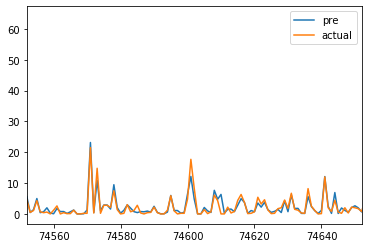

In [16]:
fig, ax = plt.subplots()
ax.plot(x_test['id'].tolist(), y_predicted, label="pre")
ax.plot(x_test['id'].tolist(), y_test, label="actual")
ax.legend()

randomStartIndex = rnd.randrange(1,len(x_test) - 101)
plt.xlim(randomStartIndex, randomStartIndex + 100 )
plt.show()

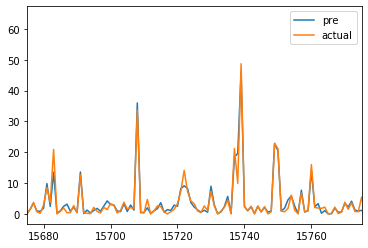

In [17]:
fig, ax = plt.subplots()
ax.plot(x_test['id'].tolist(), y_predicted, label="pre")
ax.plot(x_test['id'].tolist(), y_test, label="actual")
ax.legend()

randomStartIndex = rnd.randrange(1,len(x_test) - 101)
plt.xlim(randomStartIndex, randomStartIndex + 100 )
plt.show()

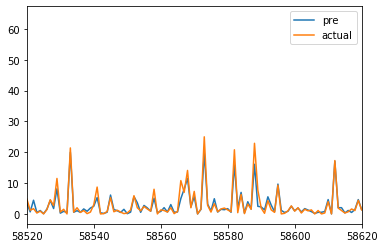

In [20]:
fig, ax = plt.subplots()
ax.plot(x_test['id'].tolist(), y_predicted, label="pre")
ax.plot(x_test['id'].tolist(), y_test, label="actual")
ax.legend()

randomStartIndex = rnd.randrange(1,len(x_test) - 101)
plt.xlim(randomStartIndex, randomStartIndex + 100 )
plt.show()




### So as we see the predicted market share is very close to the actual one!